# RUBBERY MODULUS

In [13]:
# import required packages

import traceback
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras import layers
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

### Data processing

In [14]:
# read data
filePath = r"C:\Users\Ama\OneDrive - Southern University System\01-Research\01-Data\02-Rubbery_Modulus.csv"
df = pd.read_csv(filePath)

In [15]:
#
smiles = df['SMILES']
smiles = [list(smile.strip('{} ').split(',')) for smile in smiles]

molar_ratio = df['Molar Ratio']
m_r = []
for entry in molar_ratio:
    ratio_list = [float(x) for x in entry.split(':')]
    m_r.append(ratio_list)

In [16]:
''''
functions for fingerprinting and multiplication of 
fingerprinted monomers by their respective molar ratios
'''
#function for fingerprinting
def fingerprint_monomer(monomer):
    mol = Chem.MolFromSmiles(monomer)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 10, 128)
    return fp

#function for storing fingerprints monomers as a representation of the polymers
def fingerprint_polymer(polymer):
    polymer_fp = []
    for monomer in polymer:
        monomer_fp = fingerprint_monomer(monomer)
        polymer_fp.append(monomer_fp)
    return polymer_fp

# function for multiplication by their respective molar ratios
def multiply_fingerprint(fp, m_r_value):
    return np.multiply(fp, m_r_value)

fingerprinted_polymer_data = []
for polymer, polymer_m_r in zip(smiles, m_r):
    fingerprinted_polymer = fingerprint_polymer(polymer)
    multiplied_polymer = [multiply_fingerprint(fp, m_r_value) for fp, m_r_value in zip(fingerprinted_polymer, polymer_m_r)]
    fingerprinted_polymer_data.append(multiplied_polymer)
    

#flatten the array created and storing them in a list
flattened_arr = [np.concatenate(arr) for arr in fingerprinted_polymer_data]

#find the maximum length of the flattened arrays
max_length = max(len(arr) for arr in flattened_arr)

# pad the arrays with zeros to make them the same length
padded_arrays = [np.pad(arr, (0, max_length - len(arr)), mode = 'constant') for arr in flattened_arr]

new_array = np.stack(padded_arrays)

In [17]:
X = new_array
y = df['Rubbery Modulus(MPa)'] #specify y

In [18]:
#Split data into training and testing sets
random_seed = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= random_seed)

x_plot = np.linspace(0, 12)
y_plot = x_plot

### ANN Model

Epoch 1/1000
7/7 [==============================] - 3s 72ms/step - loss: 27.5692 - mape: 96.5093 - val_loss: 36.7034 - val_mape: 146.3244
Epoch 2/1000
7/7 [==============================] - 0s 13ms/step - loss: 26.6277 - mape: 96.2253 - val_loss: 35.2903 - val_mape: 363.6320
Epoch 3/1000
7/7 [==============================] - 0s 14ms/step - loss: 24.0372 - mape: 113.9179 - val_loss: 32.0099 - val_mape: 1044.0498
Epoch 4/1000
7/7 [==============================] - 0s 13ms/step - loss: 19.9969 - mape: 172.7399 - val_loss: 31.2422 - val_mape: 2495.7861
Epoch 5/1000
7/7 [==============================] - 0s 15ms/step - loss: 19.9898 - mape: 328.7066 - val_loss: 31.5600 - val_mape: 2758.4255
Epoch 6/1000
7/7 [==============================] - 0s 27ms/step - loss: 19.1036 - mape: 295.5197 - val_loss: 31.1482 - val_mape: 2462.8682
Epoch 7/1000
7/7 [==============================] - 0s 25ms/step - loss: 18.6467 - mape: 250.7307 - val_loss: 31.5147 - val_mape: 2416.9922
Epoch 8/1000
7/7 [======

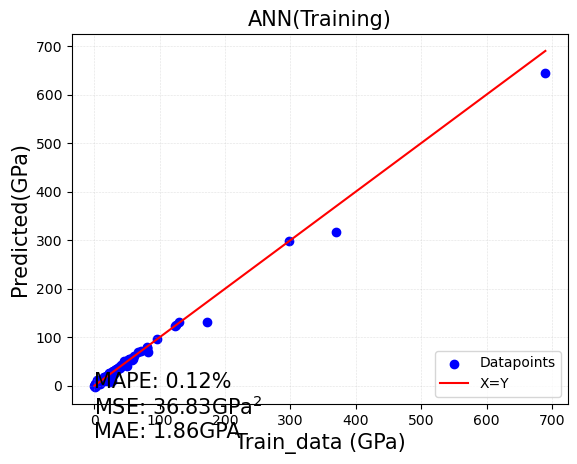

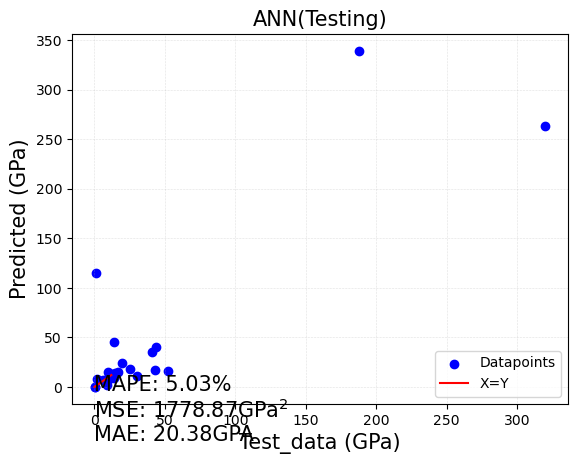

In [19]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Define the ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


# Compile the model
model.compile(loss='mae',optimizer=optimizer, metrics=['mape'])

# Train the model
history = model.fit(X_train, y_train, epochs=1000,  batch_size= 32, validation_data=(X_test, y_test))
# Predict on the test set
predicted_values = model.predict(X_test)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the error
MAPE_train = mean_absolute_percentage_error(y_train, y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test= mean_squared_error(y_test, y_test_pred)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test= mean_absolute_error(y_test, y_test_pred)


# Plot actual and predicted values for training set
plt.scatter(y_train, y_train_pred, color='b', label='Datapoints')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='r', label='X=Y')
plt.xlabel('Train_data (GPa)', fontsize=15)
plt.ylabel('Predicted(GPa)', fontsize = 15)
plt.text(-1,
        29.5,
        f"MAPE: {MAPE_train:.2f}%\nMSE: {MSE_train:.2f}GPa$^2$\nMAE: {MAE_train:.2f}GPA",
        ha="left",
        va="top",
        fontsize=15,)
plt.grid(True, which='both', linestyle='dotted', linewidth=0.4, alpha=0.7)
plt.legend(loc= 'lower right')
plt.title('ANN(Training)', fontsize= 15)
#plt.legend()
plt.show()

plt.scatter(y_test, y_test_pred, color='b', label='Datapoints')
plt.plot(x_plot, y_plot, color='r', label='X=Y')
plt.xlabel('Test_data (GPa)', fontsize = 15)
plt.ylabel('Predicted (GPa)', fontsize=15)
plt.text(-0.5,
        12.5,
        f"MAPE: {MAPE_test:.2f}%\nMSE: {MSE_test:.2f}GPa$^2$\nMAE: {MAE_test:.2f}GPA",
        ha="left",
        va="top",
        fontsize=15,)
plt.grid(True, which='both', linestyle='dotted', linewidth=0.4, alpha=0.7)
plt.legend(loc= 'lower right')
plt.title('ANN(Testing)', fontsize=15)
#plt.legend()
plt.show()